In [2]:
from PyCROSL.CRO_SL import *
from PyCROSL.AbsObjectiveFunc import *
from PyCROSL.SubstrateReal import *
from PyCROSL.SubstrateInt import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import pandas as pd
import numpy as np
import xarray as xr

import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

import sys
sys.path.insert(1, '../Modules/')
from optimisation import optimisation

In [3]:
# 1 - FEATURE SELECTION SET-UP #
# Aim: Identify optimal combinations of potential predictors 
# Method: An optimization algorithm is used to test various combinations of predictors used to recreate the HW record.
# The algorithm optimizes the N-RMSE of validation period.

In [5]:
# Set-up parameters

region="Cluj-Napoca"

# How many evaluations should be attempted? 

eval_widget = widgets.IntSlider(
    value=1000,                    # Default value
    min=500,                      # Minimum duration
    max=10000,                     # Maximum duration  
    step=500,                     # Step size
    description='Min Duration:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

eval_widget

#max_lag = 30
#max_duration = 5


IntSlider(value=1000, description='Min Duration:', layout=Layout(width='400px'), max=10000, min=500, step=500,…

In [6]:
# 3 - LOAD DATA #

In [7]:
# Potential Predictor dataset

num_eval=eval_widget.value

first_train = "7002-04-30" # training period 1600 years #
last_train = "8600-04-30" # test period 250 years
first_test = last_train
last_test = "8851-04-30"

sol_data = pd.DataFrame(columns=['CV', 'Test', 'Sol'])
indiv_file = 'Output/optimisation_output.csv'
solution_file = 'Output/optimisation_output_sol.csv'
sol_data.to_csv(indiv_file, sep=' ', header=sol_data.columns, index=None)

pred_dataframe = pd.read_csv('Predictors_dataset_past2k_weekly.csv', index_col=0)

# Number of HW days per month in past2k period, threshold = 90th percentile of 8821-8850
#ds=xr.open_dataset(f"NumberHWdays_past2k_{region}.nc")
#NDQ90=ds.NumberHWDays

            mslpEurope_cluster1  mslpEurope_cluster2  mslpEurope_cluster3  \
7001-01-01          2007.316650          -923.978879          -567.252317   
7001-01-08           170.725830          1036.114796           746.088165   
7001-01-15         -1140.379614          1105.904386          1063.464930   
7001-01-22         -1184.031442          1577.871733           696.457451   
7001-01-29          1840.005588          1703.064462           682.126816   
...                         ...                  ...                  ...   
8850-11-26         -1373.719810           794.195631           414.495757   
8850-12-03          -675.717351           303.946619           262.512978   
8850-12-10          -761.493730          -547.959173           113.833077   
8850-12-17           -60.933083          -580.093592          -283.162578   
8850-12-24          1230.059535          -562.895091          -113.908081   

            mslpEurope_cluster4  mslpEurope_cluster5  mslpWorld_cluster1  \

List of Potential Predictors
Index(['mslpEurope_cluster1', 'mslpEurope_cluster2', 'mslpEurope_cluster3',
       'mslpEurope_cluster4', 'mslpEurope_cluster5', 'mslpWorld_cluster1',
       'mslpWorld_cluster2', 'mslpWorld_cluster3', 'mslpWorld_cluster4',
       'mslpWorld_cluster5', 'smEurope_cluster1', 'smEurope_cluster2',
       'smEurope_cluster3', 'smEurope_cluster4', 'smEurope_cluster5',
       'sicArctic_cluster1', 'sicArctic_cluster2', 'sicArctic_cluster3',
       'sicArctic_cluster4', 'sicArctic_cluster5', 'sstNorthAtlantic_cluster1',
       'sstNorthAtlantic_cluster2', 'sstNorthAtlantic_cluster3',
       'sstNorthAtlantic_cluster4', 'sstNorthAtlantic_cluster5',
       'sstWorld_cluster1', 'sstWorld_cluster2', 'sstWorld_cluster3',
       'sstWorld_cluster4', 'sstWorld_cluster5', 'sstMediterranean_cluster1',
       'sstMediterranean_cluster2', 'sstMediterranean_cluster3',
       'sstMediterranean_cluster4', 'sstMediterranean_cluster5',
       'z500Europe_cluster1', 'z500Europe_clu

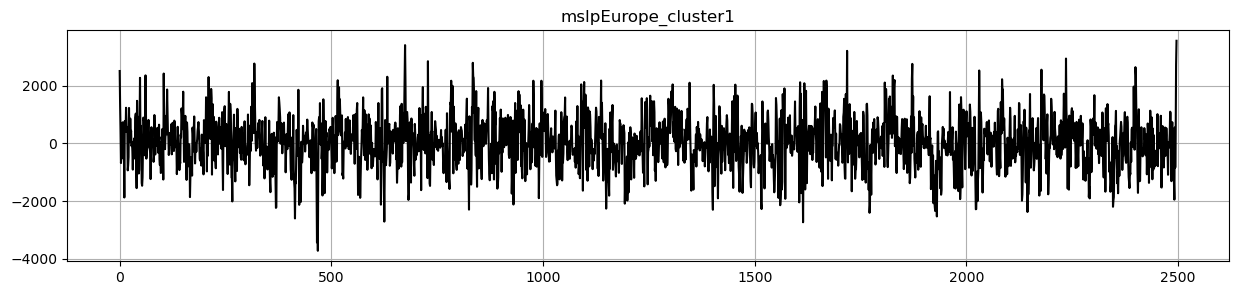

In [19]:
# Inspect the drivers

print ("List of Potential Predictors")
print (pred_dataframe.columns)

show_cluster="mslpEurope_cluster1"

plt.figure(figsize=(15,3))
plt.plot(pred_dataframe[show_cluster]['8801-01-01':'8849-01-01'].values,'k-')
plt.grid()
plt.title(show_cluster)
plt.show()



In [20]:
df = pd.read_csv(f"Output/NumberHWdays_past2k_{region}_thresh90_dur3.csv")
print (df.NumberHWDays)

target_dates=[] # dummy date for target
train_years=range(7000,8850,1)

for year in train_years:
    target_dates.append(str(year).zfill(4)+"-04-30")

target_dates=target_dates

df_NDQ90=pd.DataFrame(df.NumberHWDays.values,columns=['Target'])
df_NDQ90.index = target_dates
target_dataset=df_NDQ90


first_train_index=int(np.argwhere(df_NDQ90.index==first_train))
last_train_index=int(np.argwhere(df_NDQ90.index==last_train))

0        2.0
1        4.0
2        1.0
3        2.0
4        2.0
        ... 
1845     9.0
1846     9.0
1847    30.0
1848     3.0
1849     1.0
Name: NumberHWDays, Length: 1850, dtype: float64


In [21]:
# Initialize the objective function with size = 3 * number of predictors
objfunc = optimisation(
    size=3*pred_dataframe.shape[1],
    pred_dataframe=pred_dataframe,
    target_dataset=target_dataset,
    first_train_index=first_train_index,
    last_train_index=last_train_index,
    indiv_file=indiv_file
)

# Define CRO-SL parameters
params = {
    "popSize": 100,
    "rho": 0.6,
    "Fb": 0.98,
    "Fd": 0.2,
    "Pd": 0.8,
    "k": 3,
    "K": 20,
    "group_subs": True,

    "stop_cond": "Neval",
    "time_limit": 4000.0,
    "Ngen": 10000,
    "Neval": num_eval,
    "fit_target": 1000, 

    "verbose": True,
    "v_timer": 1,
    "Njobs": 1,

    "dynamic": True,
    "dyn_method": "success",
    "dyn_metric": "avg",
    "dyn_steps": 10,
    "prob_amp": 0.01
}

# Define operators for the algorithm
operators = [
    SubstrateInt("BLXalpha", {"F": 0.8}),
    SubstrateInt("Multipoint"),
    SubstrateInt("HS", {"F": 0.7, "Cr": 0.8, "Par": 0.2}),
    SubstrateInt("Xor"),
]

In [22]:
# Initialize and run the optimization algorithm
cro_alg = CRO_SL(objfunc, operators, params)
solution, obj_value = cro_alg.optimize()

# Save final solution
solution.tofile(solution_file, sep=',')
print(f"Optimization completed. Best objective value: {obj_value}")
print(f"Solution saved to {solution_file}")

Starting optimization of Some Function
--------------------------------------

1.0883769745447864 1.102079773020318
1.0711548095652086 1.029921202715993
1.0678366271683255 1.0473520447300855
1.0756725197447379 1.0411931375633845
1.0711154248462136 1.0560145598182749
1.0682346543928454 1.0653061062391194
1.0647311957867456 1.0721959382860382
1.0671064314823155 1.0219592152103638
1.0718798677772319 1.0511547555451226
1.0766400838411794 1.0777474914602472
1.091591053173649 1.0607561496436795
1.063058155930635 1.0733011318021781
1.0818295141554122 1.0325441183350714
1.0791024380402567 1.060024902115792
1.0453114610617278 1.0260684325985292
1.0643212801745245 1.060229652813491
1.0644877179598333 1.0915132426952316
1.0670698898348288 1.0779315546864554
1.066632420038203 1.0759953663950594
1.0697843919316186 1.059777854646897
1.0723937128105134 1.0831062599350383
1.0697851076207694 1.0034246584988036
1.0723775256295847 1.047020661484277
1.080625055075402 1.0542664763509588
1.0718911641435047 